# Projet 6 - Classifiez automatiquement des biens de consommation

# 1/ Chargement des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import re

from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
import logging

logging.disable(logging.WARNING)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
from gensim.models import Word2Vec, FastText
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

import tensorflow_hub as hub

import transformers

sns.set_style('darkgrid')

# 2/ Chargement du jeu de données

In [2]:
data = pd.read_csv('C:/Users/raflg/Downloads/OpenClassrooms/Projet 6/flipkart_com-ecommerce_sample_1050.csv')
data

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

# 3/ Exploration et nettoyage

In [3]:
#Vérification des valeurs manquantes sur les variables cibles
data.isna().mean()

uniq_id                    0.000000
crawl_timestamp            0.000000
product_url                0.000000
product_name               0.000000
product_category_tree      0.000000
pid                        0.000000
retail_price               0.000952
discounted_price           0.000952
image                      0.000000
is_FK_Advantage_product    0.000000
description                0.000000
product_rating             0.000000
overall_rating             0.000000
brand                      0.321905
product_specifications     0.000952
dtype: float64

In [4]:
#Vérification des dupliqués sur product_name
data[data.duplicated(subset='product_name', keep=False)]

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications


In [5]:
#Vérification des dupliqués sur description
data[data.duplicated(subset='description', keep=False)]

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications


### Extraction de la catégorie

In [6]:
#Fonction pour suppression des ponctuations
def clean_alt_list(list_):
    list_ = list_.replace('["', '')
    list_ = list_.replace('"]', '')
    list_ = list_.replace('"', '')
    return list_

In [7]:
#Application de la fonction à la variable de catégorie
data['product_category_tree'] = data['product_category_tree'].apply(clean_alt_list)

In [8]:
#Séparation des catégories et sous catégories
y_cat_data = data['product_category_tree']
y_cat_split = y_cat_data.str.split('>>', expand=True)

In [9]:
#Vérification du taux de valeurs manquantes pour choisir le nombre de sous catégories
y_cat_split.isna().mean()

0    0.000000
1    0.000000
2    0.002857
3    0.353333
4    0.614286
5    0.879048
6    0.945714
dtype: float64

In [10]:
#Conservation de la catégorie principale
y_cat_final_bis = y_cat_split[0]
#Catégorie +  première sous catégorie
y_cat_final = y_cat_split[[0, 1]].apply('>>'.join, axis=1)

In [11]:
print(len(y_cat_final.unique()))
print(len(y_cat_final_bis.unique()))

63
7


In [12]:
#Vérification de l'équilibre des classes
y_cat_final_bis.value_counts()

Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: 0, dtype: int64

In [13]:
#Liste des catégories
y_cat = list(y_cat_final_bis.unique())

In [14]:
#Encodage de la catégorie
y_cat_num = LabelEncoder().fit_transform(y_cat_final_bis)

In [15]:
data['category'] = y_cat_final_bis
data['category_encoded'] = y_cat_num

# 4/ Traitement de texte

## 4.1/ Concaténation du nom du produit et de sa description

In [111]:
data['product_name_description'] = data[['product_name', 'description']].agg('-'.join, axis=1)

## 4.2/ Prétraitement du texte

In [112]:
data['product_name_description'][0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain-Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

### Création des fonctions de pré-traitement

In [113]:
#Antonymes
def antonym_fct(text):
    words = nltk.word_tokenize(text)
    new_words = []
    temp_word = ''
    for word in words:
        antonyms = []
        if word == 'not':
            temp_word = 'not_'
        elif temp_word == 'not_':
            for syn in wordnet.synsets(word):
                for s in syn.lemmas():
                    for a in s.antonyms():
                        antonyms.append(a.name())
            if len(antonyms) >= 1:
                word = antonyms[0]
            else:
                word = temp_word + word
            temp_word = ''
        if word != 'not':
            new_words.append(word)
    return ' '.join(new_words)

#Tokenizer
def tokenizer_fct(text):
    text_clean = text.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ').replace('.', ' ')
    word_tokens = word_tokenize(text_clean)
    return word_tokens

#Suppression des alphanumériques
def alphanum_fct(list_words):
    non_alpha_w = [w for w in list_words if w.isalnum()]
    return non_alpha_w

#Suppression des chiffre
def number_fct(list_words):
    non_numb_w = [w for w in list_words if not w.isnumeric()]
    return non_numb_w
    
#Stop words
stop_words = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w in stop_words]
    return filtered_w

#Lower case
def lower_start_fct(list_words):
    lw = [w.lower() for w in list_words]
    return lw

#Lemmatization
def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

#Fonction de premier prétraitement (hors deep learning)
def transform_1_fct(text):
    ant = antonym_fct(text)
    word_tokens = tokenizer_fct(ant)
    aw = alphanum_fct(word_tokens)
    nw = number_fct(aw)
    sw = stop_word_filter_fct(nw)
    lw = lower_start_fct(sw)
    lm = lemma_fct(lw)
    transf_desc_text = ' '.join(lm)
    return transf_desc_text

In [114]:
#Application du pré-traitement
data['desc_preprocess'] = data['product_name_description'].apply(lambda x : transform_1_fct(x))

In [115]:
data['desc_preprocess'][0]

'elegance polyester multicolor abstract eyelet door curtain key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain cm height pack price r this curtain enhances look interior this curtain made high quality polyester fabric it feature eyelet style stitch metal ring it make room environment romantic loving this curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design the surreal attention sure steal heart these contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance designed for door type eyelet model name abstract poly

### Comptage de mots

In [116]:
tokens_count = word_tokenize(' '.join(data['desc_preprocess']))

In [117]:
#Fréquence de chaque mot
freq_ = FreqDist()

for token in tokens_count:
    freq_[token] += 1

In [118]:
words_list = []
for token, i in freq_.items():
    words_list.append(token)

In [119]:
print(f'Nombre de mots : {len(freq_)}')
print('')

#15 mots les plus utilisés
most_15_tokens = freq_.most_common(15)

words_m15 = []
for k, i in most_15_tokens:
    words_m15.append(k)
    
print(f'15 mots les plus utilisés : {words_m15}')
print('')

#15 mots les moins utilisés
less_15_tokens = freq_.most_common()[-15:]

words_l15 = []
for k, i in less_15_tokens:
    words_l15.append(k)
    
print(f'15 mots les moins utilisés : {words_l15}')
print('')

#Compte de mots uniques
unique_count = 0

for i in freq_:
    if freq_[i] == 1:
        unique_count += 1

print(f'Compte de mots uniques : {unique_count}')

Nombre de mots : 5037

15 mots les plus utilisés : ['r', 'product', 'for', 'only', 'cm', 'free', 'buy', 'replacement', 'delivery', 'genuine', 'shipping', 'cash', 'price', 'day', 'mug']

15 mots les moins utilisés : ['clinic', 'apron', 'uniform', 'vastu', 'aura', 'negativity', 'disintegrates', 'disintegrating', 'main', 'rotate', 'clockwise', 'amplifies', 'intention', 'played', 'deeper']

Compte de mots uniques : 1123


### Création des fonctions de visualisation

In [120]:
#ACP, Kmeans
def reduce_dim_fct(features, y_cat_num):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, 
                init='random', learning_rate=200, random_state=0)
    X_tsne = tsne.fit_transform(features)
    
    num_labels=len(set(y_cat_num))
    kmeans = KMeans(n_clusters=num_labels, n_init=100, random_state=0)
    kmeans.fit(X_tsne)
    
    return X_tsne, kmeans.labels_
    

#ARI
def ARI_fct(y_cat_num, labels):
    ARI = np.round(adjusted_rand_score(y_cat_num, labels),4)
    print('ARI : ', ARI)
    
    return ARI


#Visualisation
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=y_cat_num, cmap='tab10')
    ax.legend(handles=scatter.legend_elements()[0], labels=list(set(y_cat_num)), loc='best', title='Catégorie')
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap='tab10')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc='best', title='Clusters')
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print('ARI : ', ARI)

## 4.3/ Bag of words

In [121]:
#Création du bag of words
bow_vectorizer = CountVectorizer(stop_words='english')

desc_bow_vectors = bow_vectorizer.fit_transform(data['desc_preprocess'])

In [122]:
desc_bow_vectors.shape

(1050, 4817)

In [123]:
#Nombre de mots initial
len(words_list)

5037

In [124]:
#Nombre de mots du BoW
bow_w = []
for w, i in bow_vectorizer.vocabulary_.items():
    bow_w.append(w)

len(bow_w)

4817

In [125]:
#Différence entre les deux
#Certains stopwords n'ont pas été supprimés (ou ils se sont créés avec la lemmatization)
np.setdiff1d(words_list, bow_w)

array(['5', 'a', 'about', 'across', 'after', 'all', 'almost', 'along',
       'also', 'although', 'always', 'am', 'among', 'amongst', 'amount',
       'an', 'and', 'another', 'any', 'anyone', 'anything', 'anywhere',
       'are', 'around', 'at', 'b', 'back', 'be', 'because', 'become',
       'becomes', 'been', 'before', 'behind', 'being', 'besides',
       'beyond', 'bottom', 'but', 'by', 'c', 'call', 'can', 'co', 'd',
       'de', 'detail', 'do', 'done', 'down', 'due', 'during', 'e', 'each',
       'either', 'else', 'enough', 'etc', 'even', 'ever', 'every',
       'everyone', 'everything', 'f', 'few', 'fill', 'find', 'fire',
       'first', 'five', 'for', 'found', 'four', 'from', 'front', 'full',
       'g', 'get', 'give', 'go', 'h', 'have', 'he', 'hence', 'her',
       'here', 'herein', 'hers', 'him', 'his', 'how', 'however',
       'hundred', 'i', 'if', 'in', 'indeed', 'is', 'it', 'k', 'keep', 'l',
       'last', 'least', 'm', 'made', 'many', 'may', 'me', 'might', 'mill',
       'mo

In [126]:
#Calcul du score ARI
X_tsne, labels = reduce_dim_fct(desc_bow_vectors, y_cat_num)
print('BoW : ')
print('-----------------')
ARI = ARI_fct(y_cat_num, labels)

BoW : 
-----------------
ARI :  0.4622


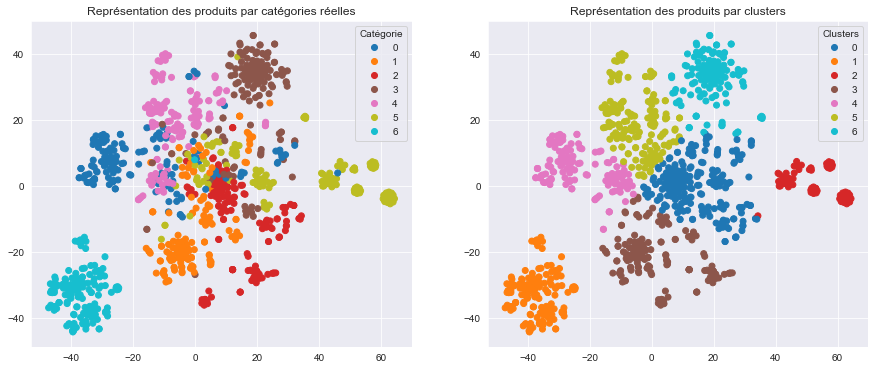

ARI :  0.4622


In [127]:
#Visualisation des catégories réelles et des clusters
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## 4.4/ TF-IDF

In [128]:
#Création du TF-IDF
tf_vectorizer = TfidfVectorizer(stop_words='english')

desc_tf_vectors = tf_vectorizer.fit_transform(data['desc_preprocess'])

In [129]:
desc_tf_vectors.shape

(1050, 4817)

In [130]:
#Nombre de mots du TF-IDF
tfidf_w = []
for w, i in bow_vectorizer.vocabulary_.items():
    tfidf_w.append(w)

len(tfidf_w)

4817

In [131]:
#Certains stopwords n'ont pas été supprimés (ou ils se sont créés avec la lemmatization)
np.setdiff1d(words_list, tfidf_w)

array(['5', 'a', 'about', 'across', 'after', 'all', 'almost', 'along',
       'also', 'although', 'always', 'am', 'among', 'amongst', 'amount',
       'an', 'and', 'another', 'any', 'anyone', 'anything', 'anywhere',
       'are', 'around', 'at', 'b', 'back', 'be', 'because', 'become',
       'becomes', 'been', 'before', 'behind', 'being', 'besides',
       'beyond', 'bottom', 'but', 'by', 'c', 'call', 'can', 'co', 'd',
       'de', 'detail', 'do', 'done', 'down', 'due', 'during', 'e', 'each',
       'either', 'else', 'enough', 'etc', 'even', 'ever', 'every',
       'everyone', 'everything', 'f', 'few', 'fill', 'find', 'fire',
       'first', 'five', 'for', 'found', 'four', 'from', 'front', 'full',
       'g', 'get', 'give', 'go', 'h', 'have', 'he', 'hence', 'her',
       'here', 'herein', 'hers', 'him', 'his', 'how', 'however',
       'hundred', 'i', 'if', 'in', 'indeed', 'is', 'it', 'k', 'keep', 'l',
       'last', 'least', 'm', 'made', 'many', 'may', 'me', 'might', 'mill',
       'mo

In [132]:
#Différence de mots entre le BoW et TF-IDF
np.setdiff1d(tfidf_w, bow_w)

array([], dtype='<U23')

In [133]:
#Calcul du score ARI
X_tsne, labels = reduce_dim_fct(desc_tf_vectors, y_cat_num)
print('TF-IDF : ')
print('-----------------')
ARI = ARI_fct(y_cat_num, labels)

TF-IDF : 
-----------------
ARI :  0.6326


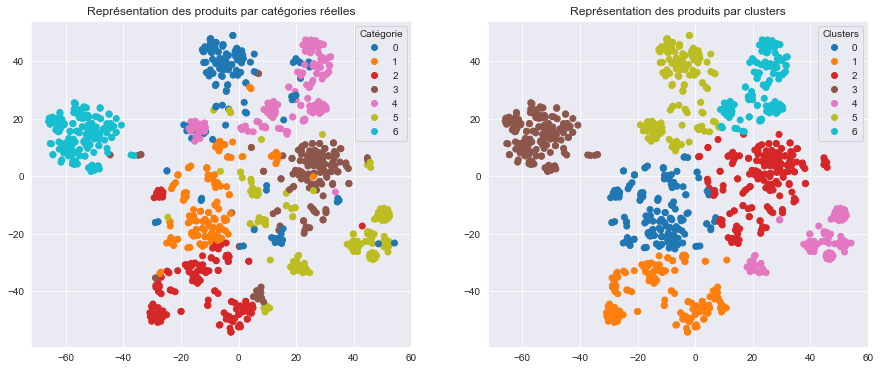

ARI :  0.6326


In [134]:
#Visualisation des catégories réelles et des clusters
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### Matrice de confusion

0(Watches):5
<br>1(Home Decor & Festive Needs):0
<br>2(Home Furnishing):1
<br>3(Kitchen & Dining):2
<br>4(Computers):6
<br>5(Baby Care):4
<br>6(Beauty and Personnal Care):3

In [135]:
#Création d'un jeu de données pour la matrice de confusion
test = pd.Series(y_cat_final_bis, name='category').to_frame()
test['label'] = labels
#Réattribution des bonnes catégories
test['label'].replace({0:1, 1:2, 2:3, 3:6, 4:5, 5:0, 6:4}, inplace=True)
test['cat_encoded'] = y_cat_num

Text(0.5, 1.0, 'Matrice de confusion des catégories réelles et des clusters avec TF-IDF')

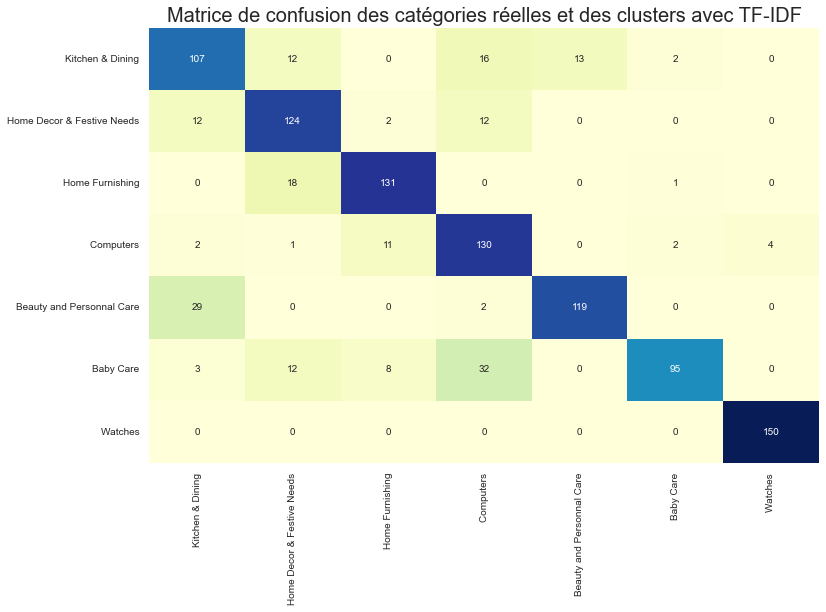

In [136]:
#Calcul et visualisation de la matrice de confusion
df_cm = pd.DataFrame(confusion_matrix(test['cat_encoded'], test['label']), 
                     index=['Kitchen & Dining ', 'Home Decor & Festive Needs ', 'Home Furnishing ',
                            'Computers ', 'Beauty and Personnal Care ', 'Baby Care ', 'Watches '],
                     columns=['Kitchen & Dining ', 'Home Decor & Festive Needs ', 'Home Furnishing ',
                              'Computers ', 'Beauty and Personnal Care ', 'Baby Care ', 'Watches '])

plt.figure(figsize=(12, 8))
sns.heatmap(df_cm, annot=True, cmap='YlGnBu', cbar=False, fmt='d')
plt.title('Matrice de confusion des catégories réelles et des clusters avec TF-IDF', fontsize=20)

### Bonus : Classifieur

In [146]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.ensemble import GradientBoostingClassifier

In [138]:
#Création du KBinsDiscretizer pour stratifier les jeux d'entrainement et de test
KBD = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
stratify_ = KBD.fit_transform(np.array(y_cat_num).reshape(-1, 1))

In [140]:
#Séparation des données en jeu de d'entrainement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(desc_tf_vectors, y_cat_num, 
                                                    test_size=0.2, stratify=stratify_, random_state=0)

scaler = StandardScaler(with_mean=False)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [144]:
tsvd = TruncatedSVD(n_components=100)
tsvd.fit(X_train_std)

X_train_tsvd = tsvd.transform(X_train_std)
X_test_tsvd = tsvd.transform(X_test_std)

In [151]:
model = GradientBoostingClassifier(n_estimators=200, random_state=0)

model.fit(X_train_tsvd, y_train)
model.score(X_test_tsvd, y_test)

0.7619047619047619

## 4.5/ Word2Vec

In [446]:
#Longueur maximale des textes
max_len = 393

In [447]:
#Prétraitement des textes
sentences = data['desc_preprocess'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [448]:
#Création du modèle
w2v_model = Word2Vec(min_count=1, window=5, vector_size=300, seed=42, workers=1, sg=0)

#Création du vocabulaire
w2v_model.build_vocab(sentences)

#Entrainement du modèle
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
#Liste des vecteurs des mots
model_vectors = w2v_model.wv
#Liste des mots
w2v_words = model_vectors.index_to_key
print(f'Taille du vocabulaire {len(w2v_words)}')

Vocabulary size: 4734


In [449]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
#pad_sequences : pour taille maximale d'une phrase
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=max_len, padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print(f'Nombre de mots uniques: {num_words}')

Number of unique words: 4735


In [450]:
w2v_size = 300
#Dictionnaire de mots (+ index) de la tokenization
word_index = tokenizer.word_index
#Nombre de mots de la tokenization
vocab_size = num_words
embedding_matrix = np.zeros((vocab_size, w2v_size)) #Lignes (nombre de mots) colonnes (w2v_size)
i=0
j=0
    
for word, idx in word_index.items(): #Dictionnaire des mots (+ index)
    i +=1
    if word in w2v_words: #Liste des mots du Word2Vec entrainé
        j +=1
        #Vérification que le mot a un vecteur dans le Word2Vec
        embedding_vector = model_vectors[word] #Vecteurs des mots du Word2Vec entrainé
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print(f'Word embedding ratio : {word_rate}')
print(f'Embedding matrix: {str(embedding_matrix.shape)}')

Word embedding rate :  1.0
Embedding matrix: (4735, 300)


In [451]:
word_input = Input(shape=(max_len, ), dtype='float64')

word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights = [embedding_matrix],
                           input_length=max_len)(word_input)

word_vec = GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 393)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 393, 300)          1420500   
                                                                 
 global_average_pooling1d_9   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,420,500
Trainable params: 1,420,500
Non-trainable params: 0
_________________________________________________________________


In [452]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 1s 11ms/step


(1050, 300)

In [453]:
#Calcul du score ARI
X_tsne, labels = reduce_dim_fct(embeddings, y_cat_num)
ARI = ARI_fct(y_cat_num, labels)

ARI :  0.4329


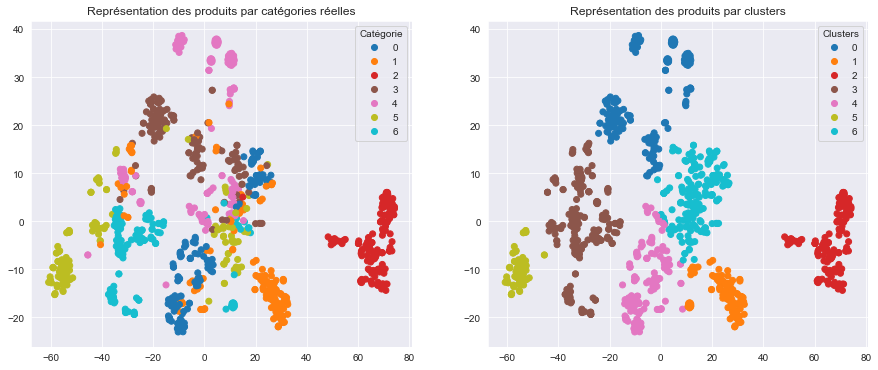

ARI :  0.4329


In [454]:
#Visualisation des catégories réelles et des clusters
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## 4.6/ Doc2Vec

In [455]:
#Création des documents avec un label
tagged_prod = [TaggedDocument(words=word_tokenize(data['desc_preprocess'][i]), 
                              tags=['P'+str(i+1)])for i in range(len(data['desc_preprocess']))]

In [456]:
len(tagged_prod)

1050

In [457]:
tagged_prod[0]

TaggedDocument(words=['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'this', 'curtain', 'enhances', 'look', 'interior', 'this', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'it', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'it', 'make', 'room', 'environment', 'romantic', 'loving', 'this', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance', 'give', 'home', 'bright', 'modernistic', 'appeal', 'design', 'the', 'surreal', 'attention', 'sure', 'steal', 'heart', 'these', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw',

In [458]:
d2v_model = Doc2Vec(min_count=1, window=5, vector_size=300, seed=42, workers=1)

d2v_model.build_vocab(tagged_prod)
d2v_model.train(tagged_prod, total_examples=d2v_model.corpus_count, epochs=100, report_delay=1)

model_vectors = d2v_model.wv
prod_vectors = d2v_model.dv
d2v_words = model_vectors.index_to_key
print(f'Taille du vocabulaire : {len(d2v_words)}')

Vocabulary size: 5037


In [459]:
embedding_matrix = np.zeros((vocab_size, w2v_size)) #Lignes (nombre de mots) colonnes (w2v_size)
i=0
j=0
    
for word, idx in word_index.items(): #Dictionnaire des mots (+ index)
    i +=1
    if word in d2v_words: #Liste de mots du Doc2Vec entrainé
        j +=1
        embedding_vector = model_vectors[word] #Vecteurs des mots du Doc2Vec entrainé
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print(f'Word embedding rate : {word_rate}')
print(f'Embedding matrix : {str(embedding_matrix.shape)}'')

Word embedding rate :  0.9613
Embedding matrix: (4735, 300)


In [460]:
word_input = Input(shape=(max_len, ), dtype='float64')

word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights = [embedding_matrix],
                           input_length=max_len)(word_input)

word_vec = GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 393)]             0         
                                                                 
 embedding_10 (Embedding)    (None, 393, 300)          1420500   
                                                                 
 global_average_pooling1d_10  (None, 300)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 1,420,500
Trainable params: 1,420,500
Non-trainable params: 0
_________________________________________________________________


In [461]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 11ms/step


(1050, 300)

In [462]:
#Calcul du score ARI
X_tsne, labels = reduce_dim_fct(embeddings, y_cat_num)
ARI = ARI_fct(y_cat_num, labels)

ARI :  0.454


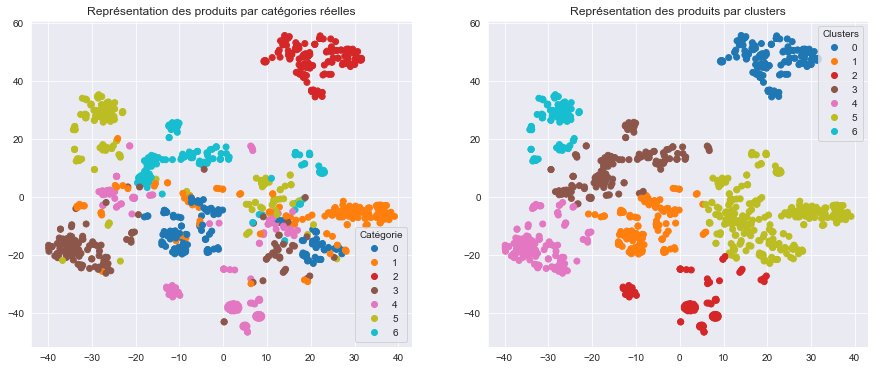

ARI :  0.454


In [463]:
#Visualisation des catégories réelles et des clusters
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## 4.7/ BERT

In [465]:
#Pré-traitement
def transform_dl_fct(text) :
    ant = antonym_fct(text)
    word_tokens = tokenizer_fct(ant)
    aw = alphanum_fct(word_tokens)
    nw = number_fct(aw)
    sw = [word for word in nw if word not in ['[', ']', ',', '.', ':', '?', '(', ')']]
    lw = lower_start_fct(sw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data['desc_preprocess_dl'] = data['product_name_description'].apply(lambda x : transform_dl_fct(x))
sentences_dl = data['desc_preprocess_dl'].tolist()

In [466]:
#Chargement du modèle BERT
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [467]:
#Fonction de préparation des textes
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[] 
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    
    
#Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size) :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = transformers.AutoTokenizer.from_pretrained(model_type)

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                               bert_tokenizer, max_length)

        text_preprocessed = {'input_word_ids' : input_ids, 
                             'input_mask' : attention_mask, 
                             'input_type_ids' : token_type_ids}
        outputs = model(text_preprocessed)
        last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
     
    return features_bert, last_hidden_states_tot

In [468]:
#Application des fonctions pour récupérer des features
features_bert, last_hidden_states_tot = feature_BERT_fct(bert_layer, 'bert-base-uncased', sentences_dl, 
                                                         64, 10)

In [469]:
features_bert.shape

(1050, 768)

In [470]:
last_hidden_states_tot.shape

(1050, 64, 768)

In [471]:
#Calcul du score ARI
X_tsne, labels = reduce_dim_fct(features_bert, y_cat_num)
ARI = ARI_fct(y_cat_num, labels)

ARI :  0.3933


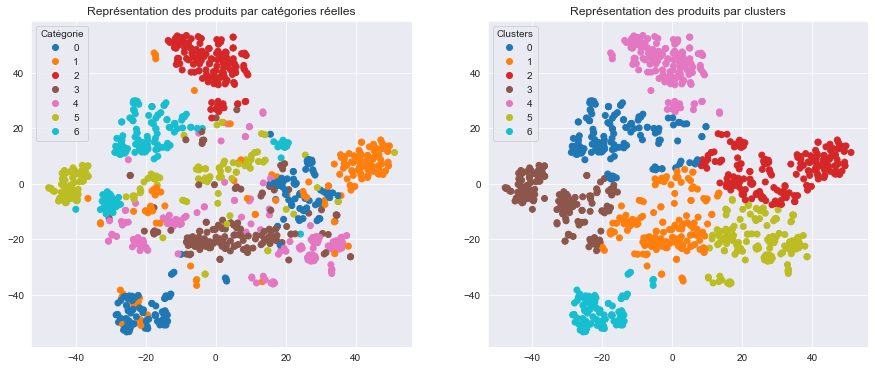

ARI :  0.3933


In [472]:
#Visualisation des catégories réelles et des clusters
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## 4.8/ USE

In [473]:
#Chargement du modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [474]:
#Fonction de création des features
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    return features

In [475]:
data['product_name_description'].tolist()

['Elegance Polyester Multicolor Abstract Eyelet Door Curtain-Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegan

In [476]:
#Application de la fonction
features_USE = feature_USE_fct(data['product_name_description'].tolist(), 10)

In [477]:
#Calcul du score ARI
X_tsne, labels = reduce_dim_fct(features_USE, y_cat_num)
ARI = ARI_fct(y_cat_num, labels)

ARI :  0.4822


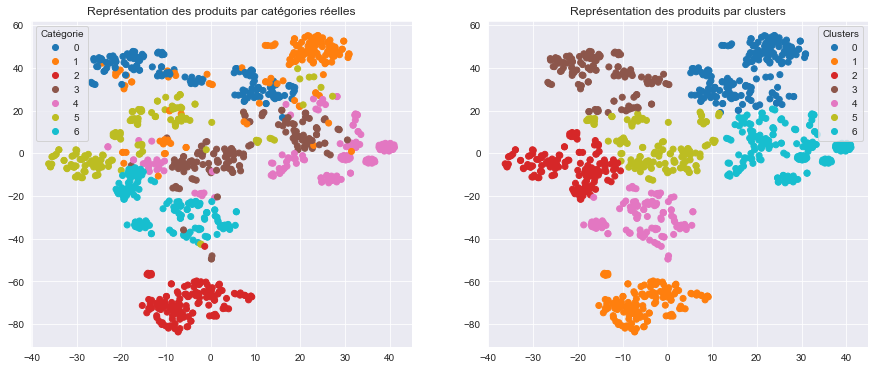

ARI :  0.4822


In [478]:
#Visualisation des catégories réelles et des clusters
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# 5/ Traitement d'image

In [16]:
from os import listdir
import cv2
from matplotlib.image import imread
from sklearn.cluster import MiniBatchKMeans

## 5.1/ Exploration

In [17]:
#Création de la liste des images
path = 'C:/Users/raflg/Downloads/OpenClassrooms/Projet 6/Images/'
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [18]:
data_img = data[['image', 'product_category_tree', 'category', 'category_encoded']].copy()
data_img

,image,product_category_tree,category,category_encoded
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing >> Curtains & Accessories >> C...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing >> Bed Linen >> Bedsheets >> S...,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing >> Bed Linen >> Bedsheets >> J...,Home Furnishing,4
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care >> Baby & Kids Gifts >> Stickers >> ...,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care >> Baby & Kids Gifts >> Stickers >> ...,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care >> Baby & Kids Gifts >> Stickers >> ...,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care >> Baby & Kids Gifts >> Stickers >> ...,Baby Care,0


In [19]:
data_img.groupby('category').count()

,image,product_category_tree,category_encoded
category,,,
Baby Care,150,150,150
Beauty and Personal Care,150,150,150
Computers,150,150,150
Home Decor & Festive Needs,150,150,150
Home Furnishing,150,150,150
Kitchen & Dining,150,150,150
Watches,150,150,150


Home Furnishing 


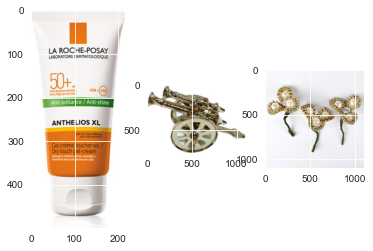

Baby Care 


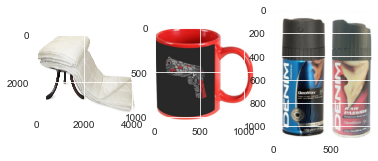

Watches 


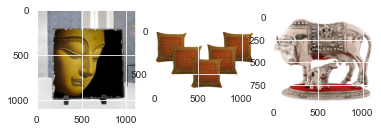

Home Decor & Festive Needs 


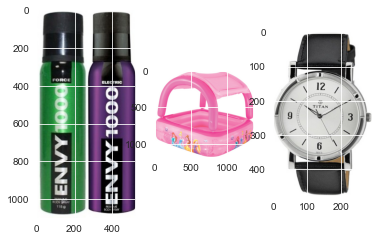

Kitchen & Dining 


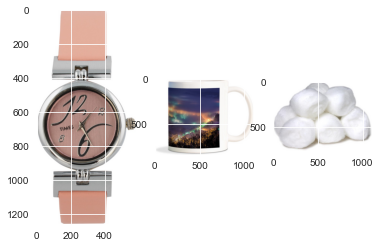

Beauty and Personal Care 


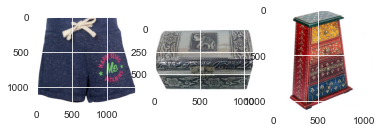

Computers 


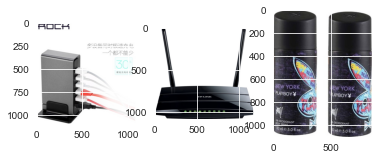

In [20]:
#Visualisation d'images par catégorie

def list_fct(cat):
    list_image_name = [list_photos[i] for i in range(len(data_img)) if data_img['category'][i]==cat]
    return list_image_name

for cat in y_cat:
    print(cat)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(cat)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

## 5.2/ SIFT

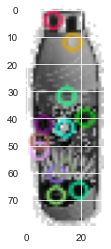

Descripteurs : (13, 128)

[[  0.   7.  43. ...   0.   0.   7.]
 [  3.  16.  33. ...   0.   0.   3.]
 [  1.  39.  65. ...   0.   0.   0.]
 ...
 [  0.   2. 136. ...   0.   0.   0.]
 [ 26.  15.   2. ...   0.   0.   0.]
 [  9. 120.  18. ...   0.   0.   6.]]


In [21]:
#Création du modèle SIFT
sift = cv2.SIFT_create()

#Chargement de l'image avec fond gris
image = cv2.imread(path+list_photos[218], cv2.IMREAD_GRAYSCALE)

#Réduction des dimensions
#% de réduction
scale_percent = 0.2
width = int(image.shape[1] * scale_percent)
height = int(image.shape[0] * scale_percent)
dim = (width, height)

#Réduction de l'image
image = cv2.resize(image, dim, interpolation=cv2.INTER_CUBIC)
#Egalisation de l'histogramme
image = cv2.equalizeHist(image)

#Récupération des key points et descripteurs
keypoints_, descriptors_ = sift.detectAndCompute(image, None)
#Affichage des descripteurs
img = cv2.drawKeypoints(image, keypoints_, image)

plt.imshow(img)
plt.show()

print(f'Descripteurs : {descriptors_.shape}')
print()
print(descriptors_)

### Application du SIFT à toutes les images

In [22]:
#Liste des descripteurs
sift_keypoints = []

sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)):
    if image_num%200 == 0: #Afficher la progression en temps réel
        print(image_num)
    image = cv2.imread(path+list_photos[image_num], cv2.IMREAD_GRAYSCALE)
    
    scale_percent = 0.2
    width = int(image.shape[1] * scale_percent)
    height = int(image.shape[0] * scale_percent)
    dim = (width, height)
    
    image = cv2.resize(image, dim, interpolation=cv2.INTER_CUBIC)
    image = cv2.equalizeHist(image)
    keypoints_, descriptors_ = sift.detectAndCompute(image, None)
    sift_keypoints.append(descriptors_)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print('Nombre de descripteurs : ', sift_keypoints_all.shape)

0
200
400
600
800
1000


C:\Users\raflg\AppData\Local\Temp\ipykernel_3740\2174387574.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)



Nombre de descripteurs :  (277304, 128)


In [23]:
# Détermination nombre de clusters
#k = int(round(np.sqrt(len(sift_keypoints_all)),0))
k = 256
print('Nombre de clusters estimés : ', k)
print('Création de', k, 'clusters de descripteurs...')

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_keypoints_all)

Nombre de clusters estimés :  256
Création de 256 clusters de descripteurs...


MiniBatchKMeans(n_clusters=256, random_state=0)

In [24]:
#Création des features

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print(f'Problème histogramme image : {image_num}')
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

#Création de la matrice des features
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    if i%200 == 0: 
        print(i)  
    hist = build_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)

0
200
400
600
800
1000


In [25]:
#Réduction de dimensions
print('Dimensions dataset avant réduction PCA : ', im_features.shape)
pca = PCA(n_components=128)
feat_pca = pca.fit_transform(im_features)
print('Dimensions dataset après réduction PCA : ', feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 256)
Dimensions dataset après réduction PCA :  (1050, 128)


In [26]:
#Application du TSNE pour la visualisation
tsne = TSNE(n_components=2, perplexity=30, 
            n_iter=2000, init='random', random_state=0)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne['category'] = data_img['category_encoded']
print(df_tsne.shape)

C:\Users\raflg\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


In [27]:
#Estimation des clusters
cls = KMeans(n_clusters=7, random_state=0)
cls.fit(X_tsne)

df_tsne['Cluster'] = cls.labels_
print(df_tsne.shape)

(1050, 4)


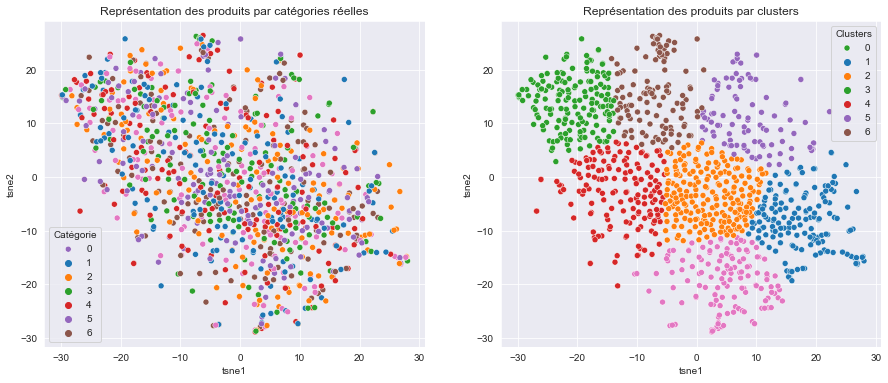

ARI :  0.0014


In [28]:
#Visualisation des catégories réelles et des clusters, et calcul du score aRI
fig = plt.figure(figsize=(15,6))
    
ax = fig.add_subplot(121)
sns.scatterplot(ax=ax, data=df_tsne, x='tsne1', y='tsne2', hue='category', palette='tab10')
ax.legend(labels=list(set(y_cat_num)), loc='best', title='Catégorie')
plt.title('Représentation des produits par catégories réelles')
    
ax = fig.add_subplot(122)
sns.scatterplot(ax=ax, data=df_tsne, x='tsne1', y='tsne2', hue='Cluster', palette='tab10')
ax.legend(labels=set(cls.labels_), loc='best', title='Clusters')
plt.title('Représentation des produits par clusters')
    
plt.show()
print('ARI : ', np.round(adjusted_rand_score(data['category_encoded'], cls.labels_), 4))

## 5.3/ CNN Transfer learning

In [32]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

In [33]:
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

for layer in model.layers:
    layer.trainable = False

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [34]:
features_list = []
cat_list = []

for i, row in data_img.iterrows():
    img_ = image.load_img(path+row['image'], target_size=(224, 224))
    
    img_ = image.img_to_array(img_)
    img_ = img_.reshape((1, img_.shape[0], img_.shape[1], img_.shape[2]))
    img_ = preprocess_input(img_)

    vgg16_feature = model.predict(img_)
    
    features_list.append(vgg16_feature)
    cat_list.append(row['category_encoded'])    

1/1 [==============================] - 0s 358ms/step


1/1 [==============================] - 1s 534ms/step


1/1 [==============================] - 0s 376ms/step


C:\Users\raflg\anaconda3\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 1s 519ms/step


1/1 [==============================] - 0s 495ms/step


In [49]:
#Application du TSNE et estimation des clusters
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(np.vstack(features_list))


num_labels = len(set(cat_list))
kmeans = KMeans(n_clusters=num_labels, n_init=100, random_state=0)
kmeans.fit(X_tsne)

C:\Users\raflg\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\raflg\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


KMeans(n_clusters=7, n_init=100, random_state=0)

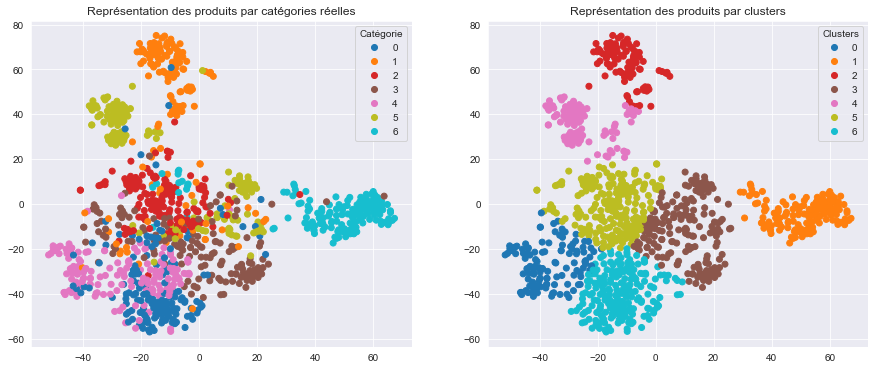

ARI :  0.4237


In [50]:
#Visualisation des catégories réelles et des clusters, et calcul du score ARI
fig = plt.figure(figsize=(15,6))
    
ax = fig.add_subplot(121)
scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=cat_list, cmap='tab10')
ax.legend(handles=scatter.legend_elements()[0], labels=list(set(cat_list)), loc='best', title='Catégorie')
plt.title('Représentation des produits par catégories réelles')
    
ax = fig.add_subplot(122)
scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeans.labels_, cmap='tab10')
ax.legend(handles=scatter.legend_elements()[0], labels=set(kmeans.labels_), loc='best', title='Clusters')
plt.title('Représentation des produits par clusters')
    
plt.show()
print('ARI : ', np.round(adjusted_rand_score(cat_list, kmeans.labels_), 4))